In [14]:
import numpy as np
import _pickle as pkl
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json
from utils import load_vh_models, frame_stack
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [15]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_osc_withGT_8C12919B740845539C0E75B5CBAF7965.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/osc"),
 'device': 'cuda:1',
 'up_to_n_pred': 8,
 'n_initial': 4,
 'n_final': 4
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [16]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device) / 100.0
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)
    
actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

In [17]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        def encode(nets, x_img, x_ft, x_arm, ctx_img):
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint": 
                    ctx = torch.cat((x_ft, x_arm), dim=-1) # (n, l, f, 12)
                elif model_args.context_modality == "ft": 
                    ctx = x_ft
                elif model_args.context_modality == "arm":
                    ctx = x_arm
                ctx = ctx.float().to(device=args.device) # (n, l, f, 6)
                ctx = ctx.transpose(-1, -2)
                ctx = ctx.reshape(-1, *ctx.shape[2:])
            
            n, l = x_img.shape[0], x_img.shape[1]
            
            if model_args.context in ["initial_image", "goal_image"]:
                x_img = torch.cat((x_img, ctx_img.repeat(1, l, 1, 1, 1)), dim=2)
            
            z_all_enc = []
            z_img = nets["img_enc"](x_img.reshape(-1, *x_img.shape[2:]))
            z_all_enc.append(z_img)  

            if model_args.context_modality != "none":
                z_context = nets["context_enc"](ctx)
                z_all_enc.append(z_context)   
            
            if model_args.context in ["initial_latent_state", "goal_latent_state"]:
                z_img_context = nets["context_img_enc"](ctx_img)
                ret_context = z_img_context
                z_img_context_rep = z_img_context.unsqueeze(1).repeat(1, l, 1)
                z_all_enc.append(z_img_context_rep.reshape(-1, *z_img_context_rep.shape[2:]))        
            elif model_args.context in ["all_past_states"]:
                if l > 1:
                    z_img_context, h_img_context = nets["context_img_rnn_enc"](
                        z_img.reshape(n, l, *z_img.shape[1:])[:, :-1].transpose(1,0)
                    )
                    pad = torch.zeros((1, *z_img_context.shape[1:])).float().to(device=args.device)
                    z_img_context = torch.cat((pad, z_img_context), dim=0)
                    z_img_context = z_img_context.transpose(1, 0)
                    ret_context = (z_img_context, h_img_context)
                else:
                    z_img_context = torch.zeros((n, l, 16)).float().to(device=args.device)
                    ret_context = (z_img_context, None)
                z_all_enc.append(z_img_context.reshape(-1, *z_img_context.shape[2:]))
            else:
                ret_context = None
                        
            z_cat_enc = torch.cat(z_all_enc, dim=-1)
            z, mu_z, logvar_z = nets["mix"](z_cat_enc)
            var_z = torch.diag_embed(torch.exp(logvar_z))
            
            return z, mu_z, var_z, ret_context
        
        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
   
        T = model_args.frame_stacks

        assert args.n_initial + args.up_to_n_pred <= imgs.shape[1]
        assert args.n_initial >= T
   
        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] = {"mu": 0, "std": 0}
            
            # Sequence of initial images
            x_img_i = imgs[:, :args.n_initial] 
            x_img_i = frame_stack(x_img_i, frames=T)
            
            # Sequence of ground truth images
            x_img_gt = imgs[:, (args.n_initial + n_pred - args.n_final):(args.n_initial + n_pred)]
            x_img_gt = frame_stack(x_img_gt, frames=T)

            # Sequence of extra modalities
            x_ft_i = data['haptic'][:, T:args.n_initial]
            x_arm_i = data['arm'][:, T:args.n_initial]                
            x_ft_gt = data['haptic'][:, (args.n_initial + n_pred - args.n_final + 1):(args.n_initial + n_pred)]
            x_arm_gt = data['arm'][:, (args.n_initial + n_pred - args.n_final + 1):(args.n_initial + n_pred)]

            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            l_gt = x_img_gt.shape[1]
            u = actions

            if model_args.context in ["initial_latent_state", "initial_image"]:
                ctx_img = x_img_i[:, 0]
            elif model_args.context in ["goal_latent_state", "goal_image"]:
                ctx_img = x_img_gt[:, -1]
            else:
                ctx_img = None

            # Encode
            z_ini, mu_z_ini, var_z_ini, ret_context = encode(nets, x_img_i, x_ft_i, x_arm_i, ctx_img)
            z_gt, mu_z_gt, var_z_gt, _ = encode(nets, x_img_gt, x_ft_gt, x_arm_gt, ctx_img)
            
            if model_args.context in ["all_past_states"]:
                z_img_context, h_img_context = ret_context
            else:
                z_img_context = ret_context
            h_i = None
            
            # Group and prepare for prediction
            q_z_i = {"z": z_ini, "mu": mu_z_ini, "cov": var_z_ini}
            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
            u = u.transpose(1,0)

            # First run
            z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
            u_i = u[(T + 1):(1 + args.n_initial)]

            # Predict
            for jj in range(0, n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u_i, 
                    h_0=h_i, 
                    single=False
                )
                z_hat = mu_z_ip1[-1]
                z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
                u_i = u[1 + args.n_initial + jj][None]
                if model_args.context in ["all_past_states"]:
                    z_img_context_dec = z_img_context[:, -1]
                    z_cat_single_dec = torch.cat((mu_z_ip1[-1], z_img_context_dec), dim=-1)
                    x_hat_ip1 = nets["img_dec"](z_cat_single_dec)
                    z_img_ip1 = nets["img_enc"](x_hat_ip1)
                    z_img_context_ip1, h_img_context = nets["context_img_rnn_enc"](z_img_ip1.unsqueeze(0), h=h_img_context)
                    z_img_context = torch.cat((z_img_context, z_img_context_ip1.transpose(1,0)), dim=1)
                              
            # Decode 
            if model_args.context in ["all_past_states"]:
                x_hat = x_hat_ip1
            else:
                z_all_dec = []
                z_all_dec.append(z_hat)
                if model_args.context in ["initial_latent_state", "goal_latent_state"]:
                    z_all_dec.append(z_img_context)
                z_cat_dec = torch.cat(z_all_dec, dim=-1)
                x_hat = nets["img_dec"](z_cat_dec)

            x_hat = x_hat[:, 0].view(x_hat.shape[0], -1).cpu().numpy()
            x_img_gt = x_img_gt[:, -1, 0].view(x_img_gt.shape[0], -1).cpu().numpy()

            z_gt = z_gt.reshape(n, l_gt, -1)[:, -1]

            # Move to cpu, np
            z_hat = z_hat.cpu().numpy()
            z_gt = z_gt.cpu().numpy()

            n = x_img_gt.shape[0]

            batch_mse_img = np.sum(((x_img_gt - x_hat)**2), axis=-1)
            batch_mse_z = np.sum(((z_gt - z_hat)**2), axis=-1)
            print("prediction length", n_pred, "starting position", T,
                "mean mse img: ", batch_mse_img.mean(),
                "std mse img: ", batch_mse_img.std())

            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["mu"] = batch_mse_img.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["std"] = batch_mse_img.std()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["mu"] = batch_mse_z.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["std"] = batch_mse_z.std()


            batch_ssim = []
            batch_psnr = []
            for jj in range(n):
                batch_ssim.append(ssim(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
                batch_psnr.append(psnr(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
            batch_ssim = np.array(batch_ssim)
            batch_psnr = np.array(batch_psnr)

            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["mu"] = batch_ssim.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["std"] = batch_ssim.std()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["mu"] = batch_psnr.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["std"] = batch_psnr.std()


    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/nstep2_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
prediction length 1 starting position 1 mean mse img:  2.2943892 std mse img:  1.201872
prediction length 2 starting position 1 mean mse img:  2.707135 std mse img:  1.3578967
prediction length 3 starting position 1 mean mse img:  2.6278994 std mse img:  1.5561513
prediction length 4 starting position 1 mean mse img:  2.7457256 std mse img:  2.3221436
prediction length 5 starting position 1 mean mse img:  2.8766358 std mse img:  2.8165097
prediction length 6 starting position 1 mean mse img:  3.1361115 std mse img:  3.5860176
prediction length 7 starting position 1 mean mse img:  3.332299 std mse img:  4.013497
prediction length 8 starting position 1 mean mse img:  3.8522332 std mse img:  5.0909743
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/none_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
prediction length 1 st

prediction length 7 starting position 1 mean mse img:  3.2235765 std mse img:  2.0128193
prediction length 8 starting position 1 mean mse img:  3.5713642 std mse img:  2.0339553
DONE!


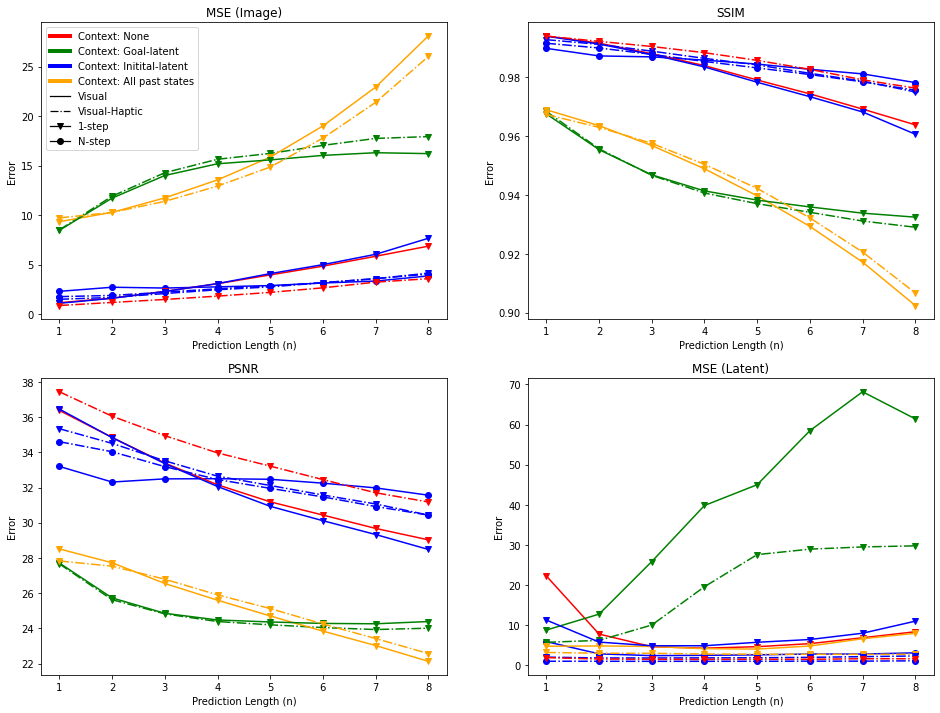

In [18]:
from matplotlib.lines import Line2D
fig, axs = plt.subplots(2, 2, figsize=(16,12))

def add_data_to_plot(name, data, var=True):
    if "vha" in name:
        linestyle = "-."
    else:
        linestyle = "-"
        
    if "nstep" in name:
        marker = "o"
    else:
        marker = "v"
        
    if "goallatent" in name:
        color = "g"
    elif "none" in name:
        color = "r"
    elif "allpaststates" in name:
        color = "orange"
    else:
        color = "b"
    
    plot_data = {'MSE_x': {"mu":[], "std":[]}, 
                 'SSIM': {"mu":[], "std":[]}, 
                 'PSNR': {"mu":[], "std":[]}, 
                 "MSE_z": {"mu":[], "std":[]}}
    for k, v in data.items():
        plot_data['MSE_x']["mu"].append(v['MSE_x']["mu"])
        plot_data['MSE_x']["std"].append(v['MSE_x']["std"])
        plot_data['SSIM']["mu"].append(v['SSIM']["mu"])
        plot_data['SSIM']["std"].append(v['SSIM']["std"])
        plot_data['PSNR']["mu"].append(v['PSNR']["mu"])
        plot_data['PSNR']["std"].append(v['PSNR']["std"])
        plot_data['MSE_z']["mu"].append(v['MSE_z']["mu"])
        plot_data['MSE_z']["std"].append(v['MSE_z']["std"])

    custom_lines = [Line2D([0], [0], color="r", lw=4),
                    Line2D([0], [0], color="g", lw=4),
                    Line2D([0], [0], color="b", lw=4),
                    Line2D([0], [0], color="orange", lw=4),
                    Line2D([0], [0], color="black", linestyle="-", lw=1.25),
                    Line2D([0], [0], color="black", linestyle="-.", lw=1.25),
                    Line2D([0], [0], color="black", marker="v", lw=1.25),
                    Line2D([0], [0], color="black", marker="o", lw=1.25)]

    axs[0,0].legend(
        custom_lines, 
        ['Context: None',
         'Context: Goal-latent', 
         'Context: Initital-latent', 
         'Context: All past states',
         'Visual', 
         'Visual-Haptic',
         '1-step',
         'N-step'], 
        loc='upper left'
    )

    axs[0,0].plot(
        list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
        plot_data['MSE_x']["mu"],
        color=color, 
        linestyle=linestyle,
        marker=marker,
    )
    if var:
        axs[0,0].fill_between(
            list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    axs[0,1].plot(
        list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
        plot_data['SSIM']["mu"],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    if var:
        axs[0,1].fill_between(
            list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    axs[1,0].plot(
        list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
        plot_data['PSNR']["mu"],
        color=color,
        linestyle=linestyle,
        marker=marker
    )
    if var:
        axs[1,0].fill_between(
            list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    axs[1,1].plot(
        list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
        plot_data['MSE_z']["mu"],
        color=color,
        linestyle=linestyle,
        marker=marker
    )
    if var:
        axs[1,1].fill_between(
            list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    
    for ii in range(axs.shape[0]):
        for jj in range(axs.shape[1]):
            axs[ii, jj].set_xlabel("Prediction Length (n)")
            axs[ii, jj].set_ylabel("Error")
            
    axs[0,0].set_title("MSE (Image)")
    axs[0,1].set_title("SSIM")
    axs[1,0].set_title("PSNR")
    axs[1,1].set_title("MSE (Latent)")


for k, v in analysis_data.items():
    add_data_to_plot(k, v, var=False)